In [ ]:
import sys
!{sys.executable} -m pip install --user progressbar2
!{sys.executable} -m pip install --user console_progressbar

In [1]:
import tarfile
import scipy.io
import numpy as np
import os
import cv2 as cv
import shutil
import random
from console_progressbar import ProgressBar

In [2]:
def ensure_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)


def save_train_data(fnames, labels, bboxes):
    src_folder = 'cars_train'
    num_samples = len(fnames)

    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)

    pb = ProgressBar(total=100, prefix='Save train data', suffix='', decimals=3, length=50, fill='=')

    for i in range(num_samples):
        fname = fnames[i]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]

        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print("{} -> {}".format(fname, label))
        pb.print_progress_bar((i + 1) * 100 / num_samples)

        if i in train_indexes:
            dst_folder = 'data/train'
        else:
            dst_folder = 'data/valid'

        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)

        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)


def save_test_data(fnames, bboxes):
    src_folder = 'cars_test'
    dst_folder = 'data/test'
    num_samples = len(fnames)

    pb = ProgressBar(total=100, prefix='Save test data', suffix='', decimals=3, length=50, fill='=')

    for i in range(num_samples):
        fname = fnames[i]
        (x1, y1, x2, y2) = bboxes[i]
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print(fname)
        pb.print_progress_bar((i + 1) * 100 / num_samples)

        dst_path = os.path.join(dst_folder, fname)
        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)


def process_train_data():
    print("Processing train data...")
    cars_annos = scipy.io.loadmat('devkit/cars_train_annos')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    class_ids = []
    bboxes = []
    labels = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        labels.append('%04d' % (class_id,))
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)

    labels_count = np.unique(class_ids).shape[0]
    print(np.unique(class_ids))
    print('The number of different cars is %d' % labels_count)

    save_train_data(fnames, labels, bboxes)


def process_test_data():
    print("Processing test data...")
    cars_annos = scipy.io.loadmat('devkit/cars_test_annos')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    bboxes = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        fname = annotation[0][4][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        fnames.append(fname)

    save_test_data(fnames, bboxes)

In [3]:
img_width, img_height = 224, 224

print('Extracting cars_train.tgz...')
if not os.path.exists('cars_train'):
    with tarfile.open('cars_train.tgz', "r:gz") as tar:
        tar.extractall()
print('Extracting cars_test.tgz...')
if not os.path.exists('cars_test'):
    with tarfile.open('cars_test.tgz', "r:gz") as tar:
        tar.extractall()
print('Extracting car_devkit.tgz...')
if not os.path.exists('devkit'):
    with tarfile.open('car_devkit.tgz', "r:gz") as tar:
        tar.extractall()

cars_meta = scipy.io.loadmat('devkit/cars_meta')
class_names = cars_meta['class_names']  # shape=(1, 196)
class_names = np.transpose(class_names)
print('class_names.shape: ' + str(class_names.shape))
print('Sample class_name: [{}]'.format(class_names[8][0][0]))

ensure_folder('data/train')
ensure_folder('data/valid')
ensure_folder('data/test')

process_train_data()
process_test_data()

# clean up
shutil.rmtree('cars_train')
shutil.rmtree('cars_test')

Extracting cars_train.tgz...
Extracting cars_test.tgz...
Extracting car_devkit.tgz...
class_names.shape: (196, 1)
Sample class_name: [Aston Martin V8 Vantage Coupe 2012]
Processing train data...
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196]
The numbe

In [4]:
import keras
from resnet_152 import resnet152_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau

img_width, img_height = 224, 224
num_channels = 3
train_data = 'data/train'
valid_data = 'data/valid'
num_classes = 196
num_train_samples = 6549
num_valid_samples = 1595
verbose = 1
batch_size = 16
num_epochs = 30
patience = 50

if __name__ == '__main__':
    # build a classifier model
    model = resnet152_model(img_height, img_width, num_channels, num_classes)

    # prepare data augmentation configuration
    train_data_gen = ImageDataGenerator(rotation_range=20.,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        zoom_range=0.2,
                                        horizontal_flip=True)
    valid_data_gen = ImageDataGenerator()
    # callbacks
    tensor_board = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
    log_file_path = 'logs/training.log'
    csv_logger = CSVLogger(log_file_path, append=False)
    early_stop = EarlyStopping('val_acc', patience=patience)
    reduce_lr = ReduceLROnPlateau('val_acc', factor=0.1, patience=int(patience / 4), verbose=1)
    trained_models_path = 'models/model'
    model_names = trained_models_path + '.{epoch:02d}-{val_acc:.2f}.hdf5'
    model_checkpoint = ModelCheckpoint(model_names, monitor='val_acc', verbose=1, save_best_only=True)
    callbacks = [tensor_board, model_checkpoint, csv_logger, early_stop, reduce_lr]

    # generators
    train_generator = train_data_gen.flow_from_directory(train_data, (img_width, img_height), batch_size=batch_size,
                                                         class_mode='categorical')
    valid_generator = valid_data_gen.flow_from_directory(valid_data, (img_width, img_height), batch_size=batch_size,
                                                         class_mode='categorical')

    # fine tune the model
    model.fit_generator(
        train_generator,
        steps_per_epoch=num_train_samples / batch_size,
        validation_data=valid_generator,
        validation_steps=num_valid_samples / batch_size,
        epochs=num_epochs,
        callbacks=callbacks,
        verbose=verbose)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 6515 images belonging to 196 classes.
Found 1629 images belonging to 196 classes.
Epoch 1/30
410/409 [==============================] - 190s 465ms/step - loss: 4.4689 - acc: 0.1113 - val_loss: 2.9121 - val_acc: 0.3025

Epoch 00001: val_acc improved from -inf to 0.30250, saving model to models/model.01-0.30.hdf5
Epoch 2/30
410/409 [==============================] - 124s 303ms/step - loss: 2.0364 - acc: 0.5290 - val_loss: 1.5068 - val_acc: 0.6150

Epoch 00002: val_acc improved from 0.30250 to 0.61500, saving model to models/model.02-0.61.hdf5
Epoch 3/30
410/409 [==============================] - 124s 303ms/step - loss: 0.9950 - acc: 0.7606 - val_loss: 0.9552 - val_acc: 0.7506

Epoch 00003: val_acc improved from 0.61500 to 0.75062, saving model to models/model.03-0.75.hdf5
Epoch 4/30
410/409 [==============================] - 125s 306ms/step - loss: 0.5919 - acc: 0.8512 - val_loss: 0.8610 - val_acc: 0.7500

Epoch 00004: val_acc did not improve from 0.75062
Epoch 5/30
410/409 [======

In [18]:
import os

import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

from utils import load_model


def decode_predictions(preds, top=5):
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [(class_names[i], pred[i]) for i in top_indices]
        result.sort(key=lambda x: x[1], reverse=True)
        results.append(result)
    return results


def predict(img_dir, model):
    img_files = []
    for root, dirs, files in os.walk(img_dir, topdown=False):
        for name in files:
            img_files.append(os.path.join(root, name))
    img_files = sorted(img_files)
    #print(img_files)

    y_pred = []
    y_test = []

    for img_path in tqdm(img_files):
        # print(img_path)
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        preds = model.predict(x[None, :, :, :])
        decoded = decode_predictions(preds, top=1)
        pred_label = decoded[0][0][0]
        # print(pred_label)
        y_pred.append(pred_label)
        tokens = img_path.split(os.path.sep)
        #print(tokens)
        class_id = int(tokens[-2])
        # print(str(class_id))
        y_test.append(class_id)

    return y_pred, y_test


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    # tick_marks = np.arange(len(classes))
    # plt.xticks(tick_marks, classes, rotation=45)
    # plt.yticks(tick_marks, classes)

    # fmt = '.2f' if normalize else 'd'
    # thresh = cm.max() / 2.
    # for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #     plt.text(j, i, format(cm[i, j], fmt),
    #              horizontalalignment="center",
    #              color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def calc_acc(y_pred, y_test):
    num_corrects = 0
    for i in range(num_samples):
        pred = y_pred[i]
        test = y_test[i]
        if pred == test:
            num_corrects += 1
    return num_corrects / num_samples


Load the trained ResNet model....






  0%|          | 0/1629 [00:00<?, ?it/s]



  0%|          | 1/1629 [00:24<10:58:05, 24.25s/it]



  0%|          | 3/1629 [00:24<7:40:33, 16.99s/it] 



  0%|          | 6/1629 [00:24<5:22:10, 11.91s/it]



  1%|          | 9/1629 [00:24<3:45:27,  8.35s/it]



  1%|          | 11/1629 [00:24<2:38:07,  5.86s/it]



  1%|          | 13/1629 [00:24<1:50:59,  4.12s/it]



  1%|          | 16/1629 [00:25<1:17:54,  2.90s/it]



  1%|          | 19/1629 [00:25<54:50,  2.04s/it]  



  1%|▏         | 21/1629 [00:25<38:46,  1.45s/it]



  1%|▏         | 24/1629 [00:25<27:30,  1.03s/it]



  2%|▏         | 26/1629 [00:25<19:41,  1.36it/s]



  2%|▏         | 29/1629 [00:25<14:07,  1.89it/s]



  2%|▏         | 32/1629 [00:25<10:15,  2.59it/s]



  2%|▏         | 35/1629 [00:25<07:33,  3.51it/s]



  2%|▏         | 38/1629 [00:26<05:38,  4.69it/s]



  3%|▎         | 41/1629 [00:26<04:18,  6.15it/s]



  3%|▎         | 44/1629 [00:26<03:24,  7.77it/s]



  3%|▎         | 47/1629 [00:26<02:46

 45%|████▍     | 728/1629 [00:56<00:38, 23.50it/s]



 45%|████▍     | 731/1629 [00:57<00:40, 22.29it/s]



 45%|████▌     | 734/1629 [00:57<00:38, 23.24it/s]



 45%|████▌     | 737/1629 [00:57<00:37, 23.99it/s]



 45%|████▌     | 740/1629 [00:57<00:36, 24.46it/s]



 46%|████▌     | 743/1629 [00:57<00:35, 24.81it/s]



 46%|████▌     | 746/1629 [00:57<00:35, 25.02it/s]



 46%|████▌     | 749/1629 [00:57<00:35, 24.51it/s]



 46%|████▌     | 752/1629 [00:57<00:35, 24.49it/s]



 46%|████▋     | 755/1629 [00:58<00:35, 24.87it/s]



 47%|████▋     | 758/1629 [00:58<00:34, 25.07it/s]



 47%|████▋     | 761/1629 [00:58<00:34, 25.03it/s]



 47%|████▋     | 764/1629 [00:58<00:34, 25.15it/s]



 47%|████▋     | 767/1629 [00:58<00:34, 25.18it/s]



 47%|████▋     | 770/1629 [00:58<00:33, 25.47it/s]



 47%|████▋     | 773/1629 [00:58<00:33, 25.47it/s]



 48%|████▊     | 776/1629 [00:58<00:33, 25.47it/s]



 48%|████▊     | 779/1629 [00:58<00:33, 25.43it/s]



 48%|████▊     | 782/1629 [0

 90%|████████▉ | 1463/1629 [01:28<00:06, 24.47it/s]



 90%|████████▉ | 1466/1629 [01:28<00:06, 24.61it/s]



 90%|█████████ | 1469/1629 [01:28<00:06, 24.74it/s]



 90%|█████████ | 1472/1629 [01:28<00:06, 24.89it/s]



 91%|█████████ | 1475/1629 [01:28<00:06, 25.00it/s]



 91%|█████████ | 1478/1629 [01:28<00:05, 25.22it/s]



 91%|█████████ | 1481/1629 [01:28<00:06, 24.33it/s]



 91%|█████████ | 1484/1629 [01:29<00:05, 24.85it/s]



 91%|█████████▏| 1487/1629 [01:29<00:05, 24.87it/s]



 91%|█████████▏| 1490/1629 [01:29<00:05, 25.01it/s]



 92%|█████████▏| 1493/1629 [01:29<00:05, 25.12it/s]



 92%|█████████▏| 1496/1629 [01:29<00:05, 24.47it/s]



 92%|█████████▏| 1499/1629 [01:29<00:05, 24.24it/s]



 92%|█████████▏| 1502/1629 [01:29<00:05, 24.67it/s]



 92%|█████████▏| 1505/1629 [01:29<00:05, 22.55it/s]



 93%|█████████▎| 1508/1629 [01:30<00:05, 21.94it/s]



 93%|█████████▎| 1511/1629 [01:30<00:05, 21.33it/s]



 93%|█████████▎| 1514/1629 [01:30<00:05, 20.92it/s]



 93%|█████

y_pred: [1, 1, 1, 1, 1, 1, 1, 1, 4, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 5, 7, 7, 36, 10, 8, 8, 9, 180, 8, 8, 8, 8, 8, 9, 8, 9, 9, 9, 9, 10, 9, 9, 26, 8, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 22, 22, 22, 13, 13, 22, 14, 19, 14, 14, 14, 19, 14, 14, 14, 14, 23, 15, 15, 15, 15, 15, 16, 16, 17, 16, 16, 16, 17, 17, 16, 17, 17, 17, 17, 17, 17, 16, 18, 16, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 14, 14, 19, 25, 19, 14, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 12, 21, 21, 21, 21, 21, 22, 11, 25, 22, 22, 22, 22, 22, 22, 22, 23, 20, 23, 23, 23, 25, 24, 24, 24, 24, 24, 24, 96, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 27, 27, 29, 29, 29, 29, 30, 29, 29, 99, 30, 30, 30, 30, 30, 30, 30, 30, 31, 36, 36, 31, 31, 31, 36, 38, 31, 31, 36, 31, 31, 36, 31, 31, 32, 32

Normalized confusion matrix
[[1.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.75 0.   ... 0.   0.   0.  ]
 [0.   0.12 0.88 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 1.   0.   0.  ]
 [0.   0.   0.   ... 0.   1.   0.  ]
 [0.   0.   0.   ... 0.   0.   1.  ]]


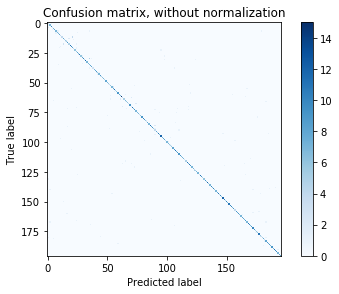

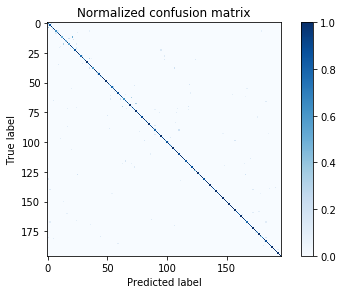

In [19]:
img_width, img_height = 224, 224
num_channels = 3
num_classes = 196
class_names = range(1, (num_classes + 1))
num_samples = 1629

print("\nLoad the trained ResNet model....")
model = load_model()

y_pred, y_test = predict('data/valid', model)
print("y_pred: " + str(y_pred))
print("y_test: " + str(y_test))

acc = calc_acc(y_pred, y_test)
print("%s: %.2f%%" % ('acc', acc * 100))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                        title='Normalized confusion matrix')

plt.show()

In [12]:
infile = r"./logs/training.log"
with open(infile) as f:
    f = f.readlines()

epoch = []
acc = []
loss = []
val_acc = []
val_loss = []
i = 1
for line in f:
    if i == 1:
        i = 0
        continue
        
    s = line.strip().split(",")
    epoch.append(int(s[0])+1)
    acc.append(round(float(s[1]),2))
    loss.append(round(float(s[2]),2))
    val_acc.append(round(float(s[3]),2))
    val_loss.append(round(float(s[4]),2))

In [3]:
print(len(acc),len(val_acc))

30 30


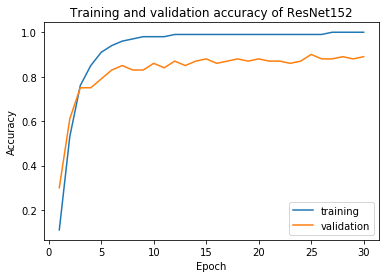

In [13]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(epoch,acc,label='training')
plt.plot(epoch,val_acc,label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy of ResNet152')
plt.legend()

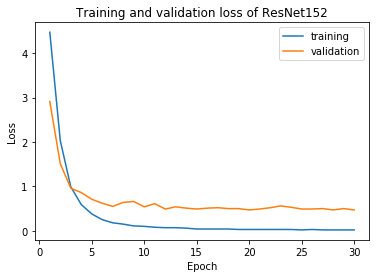

In [14]:
plt.figure(2)
plt.plot(epoch,loss,label='training')
plt.plot(epoch,val_loss,label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss of ResNet152')
plt.legend()

In [15]:
import json
import os
import random

import cv2 as cv
import keras.backend as K
import numpy as np
import scipy.io

from utils import load_model

if __name__ == '__main__':
    img_width, img_height = 224, 224
    model = load_model()
    model.load_weights('models/model.25-0.90.hdf5')

    cars_meta = scipy.io.loadmat('devkit/cars_meta')
    class_names = cars_meta['class_names']  # shape=(1, 196)
    class_names = np.transpose(class_names)

    test_path = 'data/test/'
    test_images = [f for f in os.listdir(test_path) if
                   os.path.isfile(os.path.join(test_path, f)) and f.endswith('.jpg')]

    num_samples = 20
    samples = random.sample(test_images, num_samples)
    results = []
    for i, image_name in enumerate(samples):
        filename = os.path.join(test_path, image_name)
        print('Start processing image: {}'.format(filename))
        bgr_img = cv.imread(filename)
        bgr_img = cv.resize(bgr_img, (img_width, img_height), cv.INTER_CUBIC)
        rgb_img = cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB)
        rgb_img = np.expand_dims(rgb_img, 0)
        preds = model.predict(rgb_img)
        prob = np.max(preds)
        class_id = np.argmax(preds)
        text = ('Predict: {}, prob: {}'.format(class_names[class_id][0][0], prob))
        results.append({'label': class_names[class_id][0][0], 'prob': '{:.4}'.format(prob)})
        cv.imwrite('images/{}_out.png'.format(i), bgr_img)

    print(results)
    with open('results.json', 'w') as file:
        json.dump(results, file, indent=4)

    K.clear_session()

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Start processing image: data/test/05972.jpg
Start processing image: data/test/01714.jpg
Start processing image: data/test/00258.jpg
Start processing image: data/test/01587.jpg
Start processing image: data/test/02681.jpg
Start processing image: data/test/07994.jpg
Start processing image: data/test/02328.jpg
Start processing image: data/test/02068.jpg
Start processing image: data/test/06227.jpg
Start processing image: data/test/00650.jpg
Start processing image: data/test/07154.jpg
Start processing image: data/test/00124.jpg
Start processing image: data/test/02417.jpg
Start processing image: data/test/07765.jpg
Start processing image: data/test/01119.jpg
Start processing image: data/test/07164.jpg
Start processing image: data/test/00794.jpg
Start processing image: data/test/07557.jpg
Start processing image: data/test/05668.jpg
Start processing image: data/test/07283.jpg
[{'label': 'Honda Accord Sedan 2012', 'prob': '0.7552'}, {'label': 'Chevrolet Cobalt SS 2010', 'prob': '0.9947'}, {'labe